In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read data
df = pd.read_csv('data-sets/air_passengers.csv')

# Create lagged features
for i in range(1, 3):
    df[f'lag_{i}'] = df['Passengers'].shift(i)

# Drop NA values
df.dropna(inplace=True)

# Define inputs and target
X = df[['lag_1', 'lag_2']].values
y = df['Passengers'].values


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.2 x 0.8 = 0.16


In [84]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

class FeedForwardNetwork(pl.LightningModule):
    def __init__(self, hidden_size, num_layers, input_size=2, output_size=1):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size  # Output of one layer is input to the next
        self.layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_size, output_size)  # Final output layer

    def forward(self, x):
        x = self.layers(x)
        return self.output_layer(x)        


In [88]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sympy import Integer
from torch.utils.data import DataLoader, TensorDataset


class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate, weight_decay):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y_hat = y_hat.view(-1)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y_hat = y_hat.view(-1)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

# Preparing data loaders outside the train_model function
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define a function for training a model, which we will optimize
def train_model(log_learning_rate: float, weight_decay: float, hidden_size: float, num_layers: float):
   
    # Rounding and converting to integer because BayesianOptimization gives us float values
    hidden_size = int(round(hidden_size))
    num_layers = int(round(num_layers))

    # Transform the learning rate from log space to its original space
    learning_rate = 10 ** log_learning_rate

    model = FeedForwardNetwork(hidden_size=hidden_size, num_layers=num_layers)
    lightning_model = LightningModel(model, learning_rate, weight_decay)

    # Initialize logger for this iteration
    logger = TensorBoardLogger('tb_logs', name=f'run_{len(optimizer.space)}')
    
    trainer = pl.Trainer(max_epochs=100, logger=logger)
    trainer.fit(lightning_model, train_loader, val_loader)
    
    # Return the validation loss for the last epoch
    
    return -trainer.callback_metrics['train_loss'].item()


# Defining our BayesianOptimization object
optimizer = BayesianOptimization(
    f = train_model,
    pbounds = {
        "log_learning_rate": (-5, -1), 
        "weight_decay": (1e-5, 0.1), 
        "hidden_size": (32, 128),
        "num_layers": (1, 5)  # Tuning the number of layers from 1 to 5
    },
    random_state=42,
)

# Define a UtilityFunction object, which determines how the next point to probe is picked.
utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

# Perform Bayesian optimization for 5 iterations
for _ in range(5):
    next_point_to_probe = optimizer.suggest(utility)
    target = train_model(**next_point_to_probe)
    optimizer.register(params=next_point_to_probe, target=target)


print(optimizer.max)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/oktaykurt/.pyenv/versions/3.11.2/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | FeedForwardNetwork | 14.3 K
1 | loss  | MSELoss            | 0     
---------------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)
/Users/oktaykurt/.pyenv/versions/3.11.2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloade

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


AttributeError: 'Tensor' object has no attribute 'plot'

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | FeedForwardNetwork | 14.3 K
1 | loss  | MSELoss            | 0     
---------------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


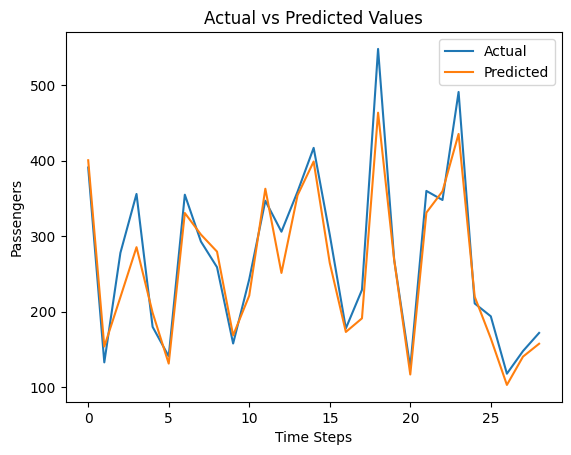

In [86]:
# Retrieve best parameters
from matplotlib import pyplot as plt

best_params = optimizer.max['params']

# Re-calculate the learning rate from its logarithm
best_params['log_learning_rate'] = 10 ** best_params['log_learning_rate']

# Ensure hidden_size and num_layers are integers
best_params['hidden_size'] = int(round(best_params['hidden_size']))
best_params['num_layers'] = int(round(best_params['num_layers']))

logger = TensorBoardLogger('tb_logs', name='my_model')

# Train a new model with the best parameters
model = FeedForwardNetwork(hidden_size=best_params['hidden_size'], num_layers=best_params['num_layers'])
lightning_model = LightningModel(model, best_params['log_learning_rate'], best_params['weight_decay'])

trainer = pl.Trainer(max_epochs=100)
trainer.fit(lightning_model, train_loader, val_loader)

# Predicting
lightning_model.eval()
predictions = lightning_model(torch.Tensor(X_test))

# Plotting
plt.plot(y_test, label='Actual')
plt.plot(predictions.detach().numpy(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Passengers')
plt.show()

In [87]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(predictions.detach().numpy(), y_test)
print("Mape:", mape)

Mape: 0.09923151827790998
